In [26]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import mmap
import random
import pickle
import argparse

parser = argparse.ArgumentParser(description='This is a demonstration program')

# parser.add_argument('-batch_size', type=str, required=True, help='Please provide a batch_size')

# args = parser.parse_args()

# print(f'batch size: {args.batch_size}')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# batch_size = args.batch_size # to use the batch_size cmd arg -> python file_name.py -batch_size 32
batch_size = 64
block_size = 256
max_iters = 10000
learning_rate = 2e-5
eval_iters = 100
n_embd = 384
n_head = 4
# n_layer = 24
n_layer = 4
dropout = 0.2

print(device)

cuda


In [27]:
chars = ""
with open("vocab.txt", 'r', encoding='utf-8') as f:
        text = f.read()
        chars = sorted(list(set(text)))
        
vocab_size = len(chars)

In [28]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

In [29]:
# memory map for using small snippets of text from a single file of any size
def get_random_chunk(split):
    filename = "openwebtext_train.txt" if split == 'train' else "openwebtext_valid.txt"
    # filename = "output_train.txt" if split == 'train' else "output_valid.txt"
    with open(filename, 'rb') as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            # Determine the file size and a random position to start reading
            file_size = len(mm)
            start_pos = random.randint(0, (file_size) - block_size*batch_size)

            # Seek to the random position and read the block of text
            mm.seek(start_pos)
            block = mm.read(block_size*batch_size-1)

            # Decode the block to a string, ignoring any invalid byte sequences
            decoded_block = block.decode('utf-8', errors='ignore').replace('\r', '')
            
            # Train and test splits
            data = torch.tensor(encode(decoded_block), dtype=torch.long)
            
    return data


def get_batch(split):
    data = get_random_chunk(split)
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [30]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# [1, 0, 0]
# [1, 0.6, 0]
# [1, 0.6, 0.4]
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out
    

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x
    
class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        
        
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index
    
    # Add methods to make the model compatible with PEFT
    def prepare_inputs_for_generation(self, input_ids, **kwargs):
        """
        Prepare inputs for generation using this model.
        This is a required method for compatibility with PEFT.
        """
        return {"index": input_ids}
        
    def get_input_embeddings(self):
        """Return the token embedding layer (required for PEFT)"""
        return self.token_embedding_table
        
    def get_output_embeddings(self):
        """Return the LM head layer (required for PEFT)"""
        return self.lm_head

# model = GPTLanguageModel(vocab_size)
# print('loading model parameters...')
with open('model-01_60k.pkl', 'rb') as f:
# with open('model-01_60k_smallData.pkl', 'rb') as f:
    model = pickle.load(f)
print('loaded successfully!')
m = model.to(device)



loaded successfully!


In [22]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

@torch.no_grad()
def estimate_acc():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        accs = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, _ = model(X, Y)
            if len(logits.shape) == 3:
                B, T, C = logits.shape
                logits = logits.view(B*T, C)
            else:
                C = logits.shape[1]
            Y = Y.view(-1)  
            pred = logits.argmax(dim=-1)
            correct = (pred == Y).float().mean()
            accs[k] = correct.item()
        out[split] = accs.mean()
    model.train()
    return out

In [15]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
itr_list = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for iter in range(max_iters):
    # print(iter)
    if iter % eval_iters == 0:
        losses = estimate_loss()
        accs = estimate_acc()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}, train acc: {accs['train']:.3f}, val acc: {accs['val']:.3f}")
        # Record metrics for plotting
        train_loss_list.append(losses['train'])
        val_loss_list.append(losses['val'])
        train_acc_list.append(accs['train'])
        val_acc_list.append(accs['val'])
        itr_list.append(iter)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

with open('model-01_10k_largeData.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

step: 0, train loss: 8.613, val loss: 8.617, train acc: 0.000, val acc: 0.000
step: 100, train loss: 5.044, val loss: 5.046, train acc: 0.271, val acc: 0.267
step: 200, train loss: 3.995, val loss: 4.006, train acc: 0.280, val acc: 0.281
step: 300, train loss: 3.335, val loss: 3.334, train acc: 0.278, val acc: 0.280
step: 400, train loss: 2.984, val loss: 2.987, train acc: 0.281, val acc: 0.286
step: 500, train loss: 2.819, val loss: 2.822, train acc: 0.288, val acc: 0.289
step: 600, train loss: 2.713, val loss: 2.720, train acc: 0.287, val acc: 0.291
step: 700, train loss: 2.666, val loss: 2.653, train acc: 0.290, val acc: 0.291
step: 800, train loss: 2.599, val loss: 2.603, train acc: 0.290, val acc: 0.292
step: 900, train loss: 2.577, val loss: 2.579, train acc: 0.293, val acc: 0.298
step: 1000, train loss: 2.556, val loss: 2.546, train acc: 0.292, val acc: 0.295
step: 1100, train loss: 2.530, val loss: 2.525, train acc: 0.293, val acc: 0.293
step: 1200, train loss: 2.514, val loss:

In [ ]:
prompt = 'The Gambia also has'
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context.unsqueeze(0), max_new_tokens=50)[0].tolist())
print(generated_chars)

TypeError: GPTLanguageModel.generate() got an unexpected keyword argument 'top_k'

In [ ]:
# Create a DataFrame with loss and accuracy metrics
import pandas as pd
df_metrics = pd.DataFrame({
    'iteration': itr_list,
    'train_loss': train_loss_list,
    'val_loss': val_loss_list,
    'train_acc': train_acc_list,
    'val_acc': val_acc_list
})

# Save to CSV
df_metrics.to_csv('training_metrics_largeData_30k.csv', index=False)

print("Metrics data saved to training_metrics_smallData_30k.csv")

Metrics data saved to training_metrics_smallData_30k.csv


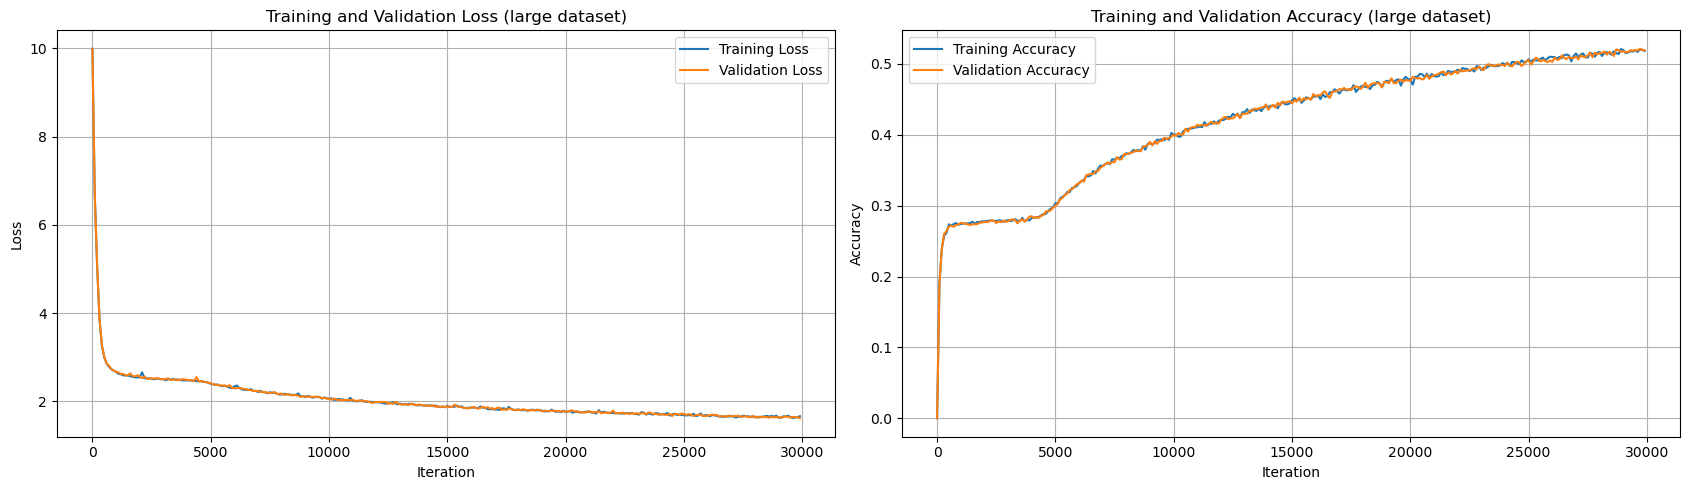

In [ ]:
import re
import pandas as pd
df_metrics = pd.read_csv('/home/max/NLP-Final-Project/results/training_metrics_largeData_30k.csv')

# Visualize training metrics
import matplotlib.pyplot as plt


def to_scalar(x):
    # if it’s a real tensor, grab its .item()
    if hasattr(x, 'item'):
        return x.item()
    # if it’s a string like "tensor(1.2345)", pull out the number
    if isinstance(x, str):
        m = re.search(r"([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)", x)
        return float(m.group()) if m else float(x)
    # otherwise just cast
    return float(x)

# apply elementwise conversion
for col in ['train_loss','val_loss','train_acc','val_acc']:
    df_metrics[col] = df_metrics[col].apply(to_scalar)
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

# Plot loss
ax1.plot(df_metrics['iteration'], df_metrics['train_loss'], label='Training Loss')
ax1.plot(df_metrics['iteration'], df_metrics['val_loss'], label='Validation Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss (large dataset)')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(df_metrics['iteration'], df_metrics['train_acc'], label='Training Accuracy')
ax2.plot(df_metrics['iteration'], df_metrics['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy (large dataset)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_metrics_largeDataset_30k.png')
plt.show()

In [7]:

from datasets import load_dataset
import torch.nn.functional as F
import math, random, tqdm

# ── Load a small slice of OASST1 ──────────────────────────────────────────
ds = load_dataset("OpenAssistant/oasst1", split="train[:2%]")   
texts = ds["text"]

def encode_safe(txt: str):
    return [string_to_int[c] for c in txt if c in string_to_int]

# ── Inject LoRA into every Linear layer ───────────────────────────────────
class LoRALinear(nn.Module):
    """Additive LoRA wrapper for a frozen `nn.Linear`."""
    def __init__(self, base: nn.Linear, r: int = 8, alpha: int = 16):
        super().__init__()
        self.base = base                     
        for p in self.base.parameters():
            p.requires_grad = False

        self.r = r
        self.scaling = alpha / r
        self.lora_A = nn.Parameter(base.weight.new_zeros((r, base.in_features)))
        self.lora_B = nn.Parameter(base.weight.new_zeros((base.out_features, r)))
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        out = self.base(x)
        delta = F.linear(x, self.lora_B @ self.lora_A) * self.scaling
        return out + delta

def _patch(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear):
            setattr(module, name, LoRALinear(child))  
        else:
            _patch(child)

_patch(model)  

# collect trainable params
lora_params = [p for p in model.parameters() if p.requires_grad]
print(f"LoRA parameters: {sum(p.numel() for p in lora_params):,}")

# ── Simple batch sampler ---------------------------------------------------
def get_batch(batch_size: int = 32):
    xs, ys = [], []
    while len(xs) < batch_size:
        ids = encode_safe(random.choice(texts))
        if len(ids) <= block_size:                 
            continue
        start = random.randint(0, len(ids) - block_size - 1)
        chunk = ids[start : start + block_size + 1]
        xs.append(chunk[:-1])
        ys.append(chunk[1:])
    x = torch.tensor(xs, dtype=torch.long, device=device)
    y = torch.tensor(ys, dtype=torch.long, device=device)
    return x, y

/home/max/anaconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LoRA parameters: 8,517,616


In [ ]:
# ── Train LoRA adapters ----------------------------------------------------
optimizer = torch.optim.Adam(lora_params, lr=1e-3)
steps = 10000                      

# Lists to track training metrics
lora_steps = []
lora_losses = []
lora_accuracies = []

# Function to compute accuracy
def compute_accuracy(logits, targets):
    # Reshape if needed
    if len(logits.shape) == 3:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
    else:
        C = logits.shape[1]
        targets = targets.view(-1)
    # Get predictions and calculate accuracy
    preds = logits.argmax(dim=-1)
    correct = (preds == targets).float().mean()
    return correct.item()

model.train()
for step in tqdm.trange(steps):
    xb, yb = get_batch()
    logits, loss = model(xb, yb)      
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record metrics every 100 steps
    if (step + 1) % 100 == 0:
        current_loss = loss.item()
        current_acc = compute_accuracy(logits, yb)
        print(f"step {step+1:>4}/{steps}  •  loss {current_loss:.4f}  •  acc {current_acc:.4f}")
        
        # Store metrics for plotting
        lora_steps.append(step + 1)
        lora_losses.append(current_loss)
        lora_accuracies.append(current_acc)

# ── Save just the adapters -------------------------------------------------
torch.save(
    {k: v.cpu() for k, v in model.state_dict().items() if "lora_" in k},
    "gptv1_lora_adapters.pt",
)
print("LoRA adapters saved to gptv1_lora_adapters.pt")


  1%|          | 103/10000 [00:07<11:10, 14.75it/s]

step  100/10000  •  loss 2.2334  •  acc 0.3997


  2%|▏         | 203/10000 [00:13<10:19, 15.81it/s]

step  200/10000  •  loss 2.0688  •  acc 0.3984


  3%|▎         | 303/10000 [00:20<10:27, 15.46it/s]

step  300/10000  •  loss 1.9535  •  acc 0.4265


  4%|▍         | 396/10000 [00:23<01:31, 105.26it/s]

step  400/10000  •  loss 1.9370  •  acc 0.4382


  5%|▌         | 503/10000 [00:30<10:41, 14.82it/s] 

step  500/10000  •  loss 1.8991  •  acc 0.4359


  6%|▌         | 603/10000 [00:37<10:36, 14.75it/s]

step  600/10000  •  loss 1.9573  •  acc 0.4396


  7%|▋         | 703/10000 [00:43<09:38, 16.06it/s]

step  700/10000  •  loss 1.9408  •  acc 0.4357


  8%|▊         | 803/10000 [00:50<09:58, 15.36it/s]

step  800/10000  •  loss 1.8311  •  acc 0.4565


  9%|▉         | 902/10000 [00:54<04:48, 31.58it/s]

step  900/10000  •  loss 1.8424  •  acc 0.4679


 10%|█         | 1003/10000 [01:00<09:03, 16.55it/s]

step 1000/10000  •  loss 1.7762  •  acc 0.4742


 11%|█         | 1103/10000 [01:07<09:14, 16.05it/s]

step 1100/10000  •  loss 1.8394  •  acc 0.4646


 12%|█▏        | 1203/10000 [01:13<09:15, 15.83it/s]

step 1200/10000  •  loss 1.8564  •  acc 0.4540


 13%|█▎        | 1303/10000 [01:19<09:01, 16.05it/s]

step 1300/10000  •  loss 1.7825  •  acc 0.4784


 14%|█▍        | 1399/10000 [01:23<01:19, 108.22it/s]

step 1400/10000  •  loss 1.7715  •  acc 0.4742


 15%|█▌        | 1503/10000 [01:29<08:37, 16.42it/s] 

step 1500/10000  •  loss 1.9160  •  acc 0.4446


 16%|█▌        | 1603/10000 [01:36<09:06, 15.35it/s]

step 1600/10000  •  loss 1.8525  •  acc 0.4569


 17%|█▋        | 1703/10000 [01:42<08:44, 15.81it/s]

step 1700/10000  •  loss 1.8507  •  acc 0.4625


 18%|█▊        | 1803/10000 [01:49<08:38, 15.81it/s]

step 1800/10000  •  loss 1.8306  •  acc 0.4600


 19%|█▉        | 1903/10000 [01:53<01:14, 109.08it/s]

step 1900/10000  •  loss 1.8001  •  acc 0.4655


 20%|██        | 2003/10000 [01:59<08:05, 16.46it/s] 

step 2000/10000  •  loss 1.8800  •  acc 0.4528


 21%|██        | 2103/10000 [02:05<08:41, 15.15it/s]

step 2100/10000  •  loss 1.6666  •  acc 0.5051


 22%|██▏       | 2203/10000 [02:12<08:31, 15.26it/s]

step 2200/10000  •  loss 1.7614  •  acc 0.4849


 23%|██▎       | 2303/10000 [02:19<09:15, 13.85it/s]

step 2300/10000  •  loss 1.6967  •  acc 0.5070


 24%|██▍       | 2400/10000 [02:23<03:27, 36.69it/s]

step 2400/10000  •  loss 1.7060  •  acc 0.5006


 25%|██▌       | 2503/10000 [02:30<08:36, 14.51it/s]

step 2500/10000  •  loss 1.7003  •  acc 0.4921


 26%|██▌       | 2603/10000 [02:37<08:07, 15.16it/s]

step 2600/10000  •  loss 1.6325  •  acc 0.5292


 27%|██▋       | 2703/10000 [02:44<08:39, 14.04it/s]

step 2700/10000  •  loss 1.6385  •  acc 0.5033


 28%|██▊       | 2803/10000 [02:51<08:39, 13.85it/s]

step 2800/10000  •  loss 1.6879  •  acc 0.5094


 29%|██▉       | 2903/10000 [02:55<07:00, 16.87it/s]

step 2900/10000  •  loss 1.7141  •  acc 0.4774


 30%|███       | 3003/10000 [03:02<07:34, 15.41it/s]

step 3000/10000  •  loss 1.6430  •  acc 0.5114


 31%|███       | 3103/10000 [03:08<07:31, 15.26it/s]

step 3100/10000  •  loss 1.7087  •  acc 0.4939


 32%|███▏      | 3203/10000 [03:15<07:31, 15.05it/s]

step 3200/10000  •  loss 1.7463  •  acc 0.4797


 33%|███▎      | 3299/10000 [03:22<07:42, 14.50it/s]

step 3300/10000  •  loss 1.6446  •  acc 0.5157


 34%|███▍      | 3403/10000 [03:27<07:46, 14.14it/s]

step 3400/10000  •  loss 1.7020  •  acc 0.4952


 35%|███▌      | 3503/10000 [03:34<07:36, 14.23it/s]

step 3500/10000  •  loss 1.6806  •  acc 0.5035


 36%|███▌      | 3603/10000 [03:41<07:31, 14.18it/s]

step 3600/10000  •  loss 1.6866  •  acc 0.5012


 37%|███▋      | 3703/10000 [03:48<07:19, 14.34it/s]

step 3700/10000  •  loss 1.7146  •  acc 0.5023


 38%|███▊      | 3794/10000 [03:52<01:06, 92.84it/s]

step 3800/10000  •  loss 1.6081  •  acc 0.5206


 39%|███▉      | 3903/10000 [03:59<07:12, 14.09it/s]

step 3900/10000  •  loss 1.7471  •  acc 0.4774


 40%|████      | 4003/10000 [04:06<07:02, 14.20it/s]

step 4000/10000  •  loss 1.6647  •  acc 0.5126


 41%|████      | 4103/10000 [04:13<06:03, 16.21it/s]

step 4100/10000  •  loss 1.6620  •  acc 0.5149


 42%|████▏     | 4203/10000 [04:19<05:58, 16.16it/s]

step 4200/10000  •  loss 1.7566  •  acc 0.4825


 43%|████▎     | 4304/10000 [04:23<03:05, 30.70it/s] 

step 4300/10000  •  loss 1.6135  •  acc 0.5159


 44%|████▍     | 4403/10000 [04:29<05:41, 16.39it/s]

step 4400/10000  •  loss 1.6365  •  acc 0.5200


 45%|████▌     | 4503/10000 [04:35<05:47, 15.83it/s]

step 4500/10000  •  loss 1.5939  •  acc 0.5250


 46%|████▌     | 4603/10000 [04:41<05:34, 16.14it/s]

step 4600/10000  •  loss 1.6966  •  acc 0.5085


 47%|████▋     | 4703/10000 [04:47<05:28, 16.13it/s]

step 4700/10000  •  loss 1.6362  •  acc 0.5204


 48%|████▊     | 4763/10000 [04:51<05:23, 16.19it/s]

step 4800/10000  •  loss 1.6548  •  acc 0.5088


 49%|████▉     | 4903/10000 [04:57<05:06, 16.64it/s] 

step 4900/10000  •  loss 1.6698  •  acc 0.5154


 50%|█████     | 5003/10000 [05:03<05:09, 16.17it/s]

step 5000/10000  •  loss 1.6464  •  acc 0.5232


 51%|█████     | 5103/10000 [05:10<05:43, 14.25it/s]

step 5100/10000  •  loss 1.6251  •  acc 0.5177


 52%|█████▏    | 5203/10000 [05:17<05:40, 14.08it/s]

step 5200/10000  •  loss 1.5013  •  acc 0.5493


 53%|█████▎    | 5294/10000 [05:21<00:47, 98.42it/s]

step 5300/10000  •  loss 1.5821  •  acc 0.5343


 54%|█████▍    | 5403/10000 [05:28<05:07, 14.95it/s]

step 5400/10000  •  loss 1.5667  •  acc 0.5378


 55%|█████▌    | 5503/10000 [05:35<04:52, 15.39it/s]

step 5500/10000  •  loss 1.6820  •  acc 0.4988


 56%|█████▌    | 5603/10000 [05:42<04:47, 15.31it/s]

step 5600/10000  •  loss 1.6059  •  acc 0.5127


 57%|█████▋    | 5703/10000 [05:48<04:31, 15.85it/s]

step 5700/10000  •  loss 1.6301  •  acc 0.5162


 58%|█████▊    | 5800/10000 [05:52<02:38, 26.55it/s]

step 5800/10000  •  loss 1.6229  •  acc 0.5190


 59%|█████▉    | 5903/10000 [05:59<04:56, 13.83it/s]

step 5900/10000  •  loss 1.6082  •  acc 0.5214


 60%|██████    | 6003/10000 [06:06<04:07, 16.13it/s]

step 6000/10000  •  loss 1.6911  •  acc 0.5139


 61%|██████    | 6103/10000 [06:12<04:16, 15.18it/s]

step 6100/10000  •  loss 1.6516  •  acc 0.5088


 62%|██████▏   | 6203/10000 [06:19<03:56, 16.06it/s]

step 6200/10000  •  loss 1.5755  •  acc 0.5393


 63%|██████▎   | 6304/10000 [06:23<02:45, 22.37it/s] 

step 6300/10000  •  loss 1.5696  •  acc 0.5399


 64%|██████▍   | 6403/10000 [06:29<04:13, 14.20it/s]

step 6400/10000  •  loss 1.5722  •  acc 0.5323


 65%|██████▌   | 6503/10000 [06:37<04:11, 13.88it/s]

step 6500/10000  •  loss 1.5882  •  acc 0.5256


 66%|██████▌   | 6603/10000 [06:44<04:02, 14.00it/s]

step 6600/10000  •  loss 1.5726  •  acc 0.5302


 67%|██████▋   | 6695/10000 [06:50<03:29, 15.78it/s]

step 6700/10000  •  loss 1.5791  •  acc 0.5250


 68%|██████▊   | 6803/10000 [06:54<03:10, 16.80it/s] 

step 6800/10000  •  loss 1.5696  •  acc 0.5358


 69%|██████▉   | 6903/10000 [07:01<03:12, 16.11it/s]

step 6900/10000  •  loss 1.6688  •  acc 0.5027


 70%|███████   | 7003/10000 [07:07<03:05, 16.17it/s]

step 7000/10000  •  loss 1.5937  •  acc 0.5247


 71%|███████   | 7103/10000 [07:13<03:00, 16.07it/s]

step 7100/10000  •  loss 1.6679  •  acc 0.5123


 72%|███████▏  | 7203/10000 [07:19<02:58, 15.64it/s]

step 7200/10000  •  loss 1.5144  •  acc 0.5514


 73%|███████▎  | 7303/10000 [07:23<02:31, 17.83it/s] 

step 7300/10000  •  loss 1.6103  •  acc 0.5227


 74%|███████▍  | 7403/10000 [07:29<02:40, 16.22it/s]

step 7400/10000  •  loss 1.6923  •  acc 0.5002


 75%|███████▌  | 7503/10000 [07:36<02:35, 16.06it/s]

step 7500/10000  •  loss 1.6225  •  acc 0.5166


 76%|███████▌  | 7603/10000 [07:42<02:28, 16.19it/s]

step 7600/10000  •  loss 1.5457  •  acc 0.5422


 77%|███████▋  | 7703/10000 [07:48<02:37, 14.62it/s]

step 7700/10000  •  loss 1.5747  •  acc 0.5292


 78%|███████▊  | 7803/10000 [07:52<01:43, 21.15it/s] 

step 7800/10000  •  loss 1.6183  •  acc 0.5111


 79%|███████▉  | 7903/10000 [07:58<02:14, 15.59it/s]

step 7900/10000  •  loss 1.6530  •  acc 0.5062


 80%|████████  | 8003/10000 [08:05<02:12, 15.07it/s]

step 8000/10000  •  loss 1.5882  •  acc 0.5302


 81%|████████  | 8103/10000 [08:12<02:02, 15.45it/s]

step 8100/10000  •  loss 1.5227  •  acc 0.5469


 82%|████████▏ | 8203/10000 [08:18<01:58, 15.18it/s]

step 8200/10000  •  loss 1.5716  •  acc 0.5314


 83%|████████▎ | 8303/10000 [08:22<01:20, 21.12it/s] 

step 8300/10000  •  loss 1.5056  •  acc 0.5496


 84%|████████▍ | 8403/10000 [08:28<01:38, 16.22it/s]

step 8400/10000  •  loss 1.6142  •  acc 0.5237


 85%|████████▌ | 8503/10000 [08:34<01:32, 16.25it/s]

step 8500/10000  •  loss 1.6085  •  acc 0.5210


 86%|████████▌ | 8603/10000 [08:41<01:26, 16.20it/s]

step 8600/10000  •  loss 1.5899  •  acc 0.5284


 87%|████████▋ | 8703/10000 [08:47<01:21, 15.94it/s]

step 8700/10000  •  loss 1.6828  •  acc 0.5120


 88%|████████▊ | 8795/10000 [08:50<00:29, 41.01it/s] 

step 8800/10000  •  loss 1.5605  •  acc 0.5403


 89%|████████▉ | 8903/10000 [08:57<01:08, 16.06it/s]

step 8900/10000  •  loss 1.5620  •  acc 0.5432


 90%|█████████ | 9003/10000 [09:03<01:01, 16.31it/s]

step 9000/10000  •  loss 1.5250  •  acc 0.5454


 91%|█████████ | 9103/10000 [09:09<00:55, 16.14it/s]

step 9100/10000  •  loss 1.6809  •  acc 0.5071


 92%|█████████▏| 9203/10000 [09:15<00:49, 16.04it/s]

step 9200/10000  •  loss 1.6249  •  acc 0.5178


 93%|█████████▎| 9263/10000 [09:19<00:45, 16.25it/s]

step 9300/10000  •  loss 1.5723  •  acc 0.5302


 94%|█████████▍| 9403/10000 [09:25<00:36, 16.55it/s] 

step 9400/10000  •  loss 1.5376  •  acc 0.5472


 95%|█████████▌| 9503/10000 [09:31<00:30, 16.10it/s]

step 9500/10000  •  loss 1.5276  •  acc 0.5388


 96%|█████████▌| 9603/10000 [09:38<00:24, 15.88it/s]

step 9600/10000  •  loss 1.6040  •  acc 0.5240


 97%|█████████▋| 9703/10000 [09:44<00:18, 16.22it/s]

step 9700/10000  •  loss 1.6515  •  acc 0.5190


 98%|█████████▊| 9785/10000 [09:49<00:13, 16.13it/s]

step 9800/10000  •  loss 1.6679  •  acc 0.5057


 99%|█████████▉| 9903/10000 [09:54<00:05, 16.63it/s] 

step 9900/10000  •  loss 1.5125  •  acc 0.5563


100%|██████████| 10000/10000 [10:00<00:00, 16.66it/s]

step 10000/10000  •  loss 1.5388  •  acc 0.5381
LoRA adapters saved to gptv1_lora_adapters.pt


NameError: name 'pd' is not defined

In [9]:
import pandas as pd
# Save training metrics to CSV
lora_metrics_df = pd.DataFrame({
    'iteration': lora_steps,
    'loss': lora_losses,
    'accuracy': lora_accuracies
})
lora_metrics_df.to_csv('lora_output/lora_training_metrics.csv', index=False)
print("LoRA training metrics saved to lora_output/lora_training_metrics.csv")

LoRA training metrics saved to lora_output/lora_training_metrics.csv


# Plot LoRA Training Metrics

Let's visualize the training loss and accuracy for the LoRA fine-tuning process.

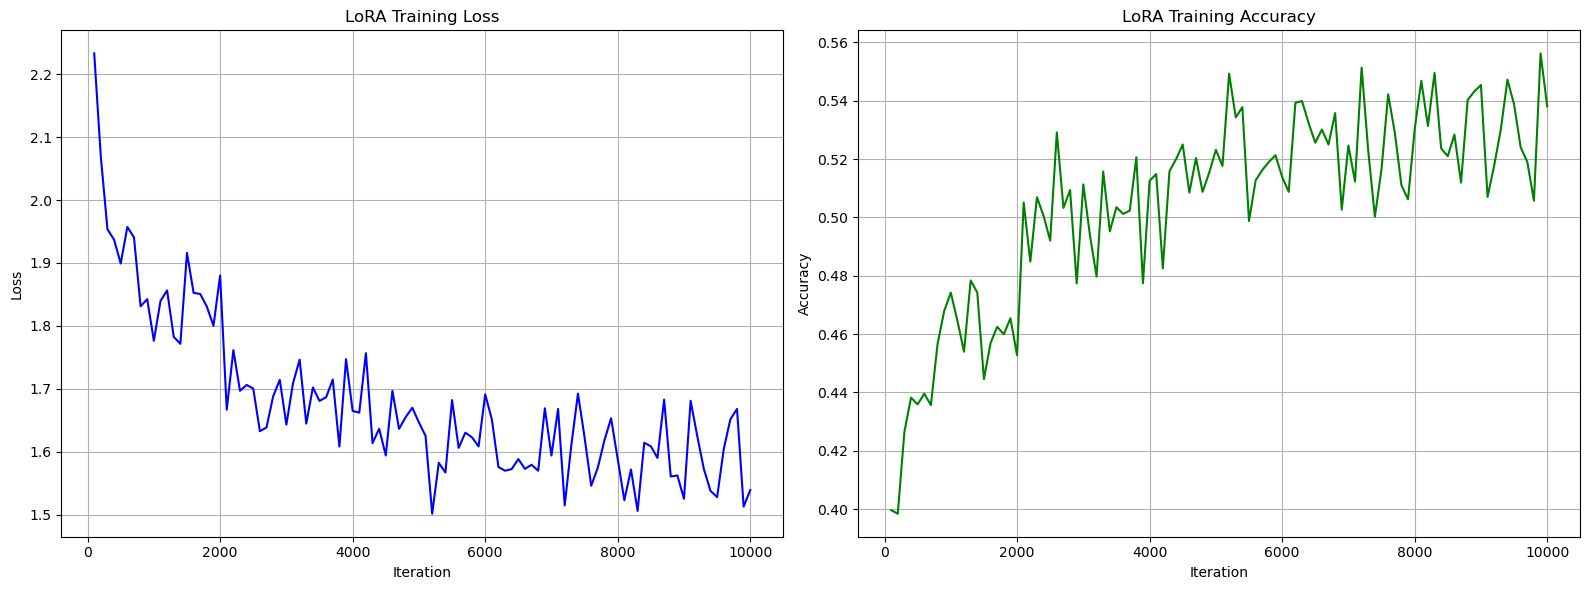

LoRA training metrics plot saved to lora_output/lora_training_metrics.png


In [10]:
# Plot LoRA training metrics
import matplotlib.pyplot as plt

# Create directory for results if it doesn't exist
import os
if not os.path.exists('lora_output'):
    os.makedirs('lora_output')

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot loss
ax1.plot(lora_steps, lora_losses, label='Training Loss', color='blue')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('LoRA Training Loss')
ax1.grid(True)

# Plot accuracy
ax2.plot(lora_steps, lora_accuracies, label='Training Accuracy', color='green')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.set_title('LoRA Training Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.savefig('lora_output/lora_training_metrics.png')
plt.show()

print("LoRA training metrics plot saved to lora_output/lora_training_metrics.png")

In [ ]:
# Display the metrics dataframe
lora_metrics_df.head(10)

In [16]:
# ------------------ Quick interactive sampling ------------------
import torch, math, random, tqdm
from types import SimpleNamespace

# (Re)build / load the base model exactly as before -------------
# model = build_gpt_v1(...)   

# Re‑inject LoRA wrappers & load the adapters ------------------
# try:
#     next(m for m in model.modules() if isinstance(m, LoRALinear))
# except StopIteration:
#     _patch(model)                               

# lora_state = torch.load("gptv1_lora_adapters.pt", map_location="cpu")
# model.load_state_dict(lora_state, strict=False)  

model.to(device).eval()

# Helper: encode / decode at char level -----------------------
def encode_safe(txt):
    return [string_to_int[c] for c in txt if c in string_to_int]

def decode(ids):
    return "".join(int_to_string[i] for i in ids)

# Generate from a user prompt ---------------------------------
prompt = "the capital of United States"      
max_new = 200
temperature = 0.8
top_k = 40

ctx = torch.tensor([encode_safe(prompt)], dtype=torch.long, device=device)
model.eval()
with torch.no_grad():
    for _ in range(max_new):
        logits, _ = model(ctx)               
        logits = logits[:, -1, :] / temperature
        if top_k:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        ctx = torch.cat([ctx, next_id], dim=1)

print("-" * 40)
print(decode(ctx[0].tolist()))
print("-" * 40)


----------------------------------------
the capital of United States, Elgo D The S3, Automation. Aquanted encluye depending the S3 back, The S3 exampless of a like start feature in Austriction filef the discriminations idea is to could curle, it if you orders and even
----------------------------------------


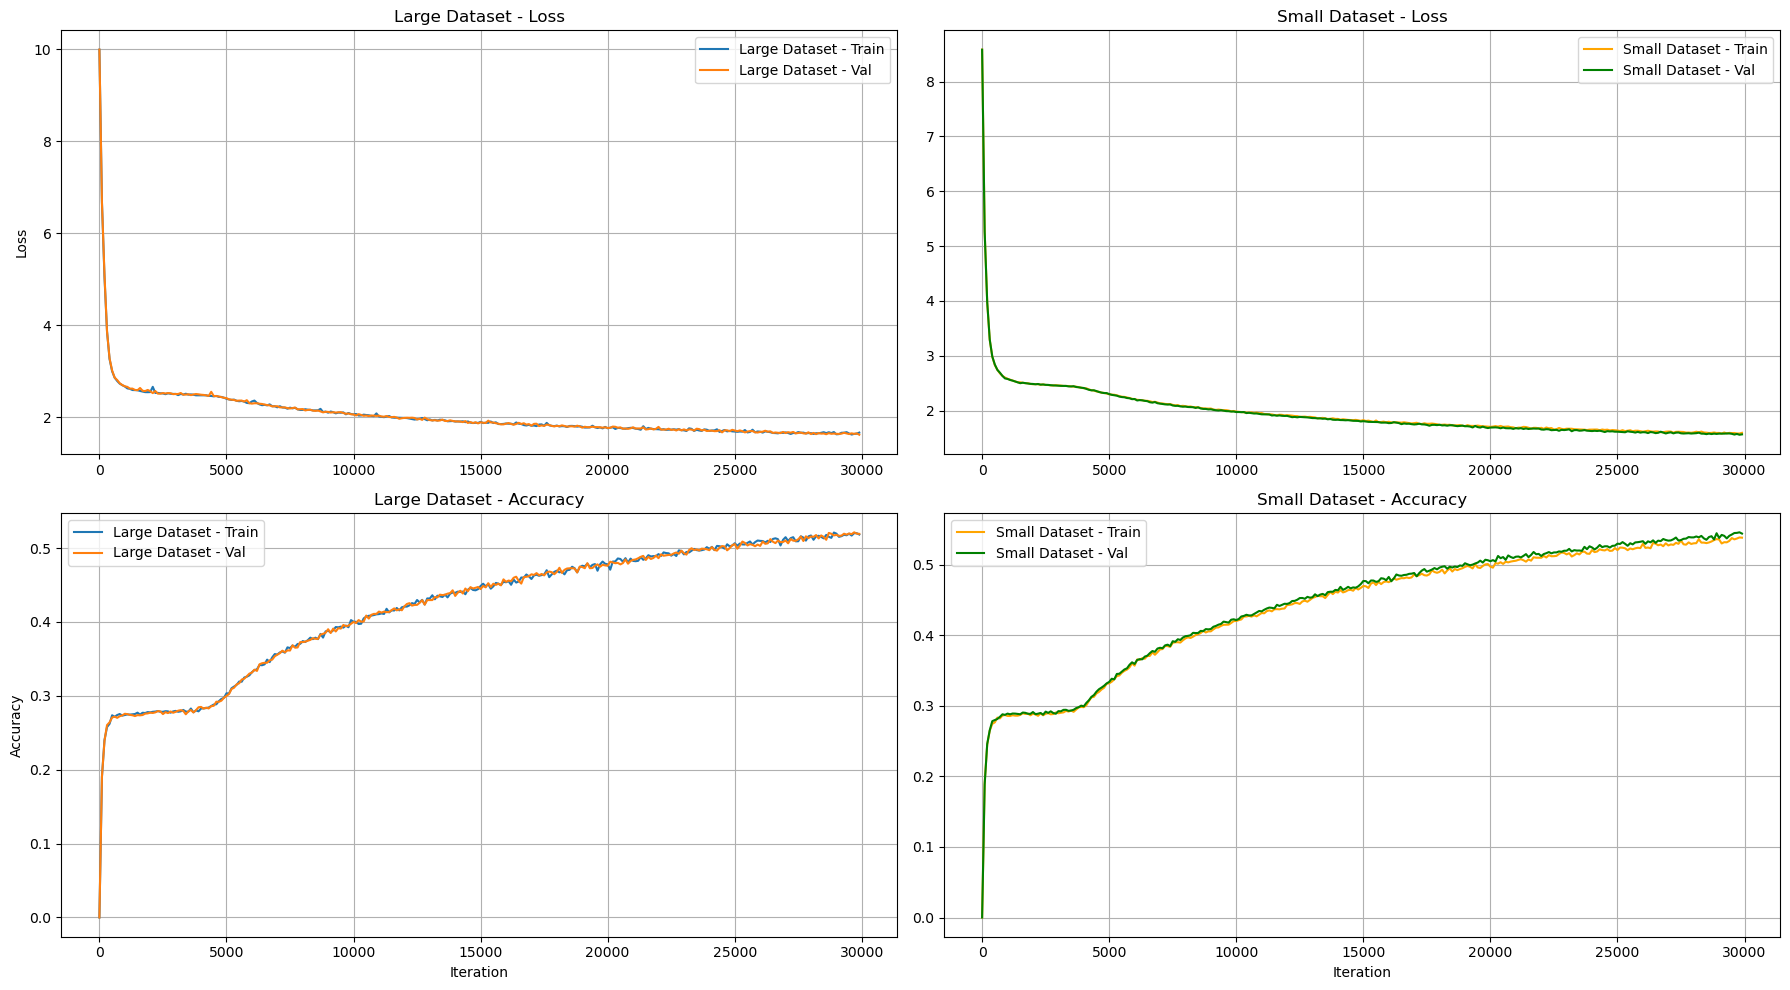

Comparison plot saved to results/training_comparison_large_vs_small.png


In [1]:
# Plot and compare metrics from both large and small datasets
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load both datasets
df_large = pd.read_csv('/home/max/NLP-Final-Project/results/training_metrics_largeData_30k.csv')
df_small = pd.read_csv('/home/max/NLP-Final-Project/results/training_metrics_smallData_30k.csv')

# Function to convert tensor strings to scalar values if needed
def to_scalar(x):
    # if it's a real tensor, grab its .item()
    if hasattr(x, 'item'):
        return x.item()
    # if it's a string like "tensor(1.2345)", pull out the number
    if isinstance(x, str):
        m = re.search(r"([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)", x)
        return float(m.group()) if m else float(x)
    # otherwise just cast
    return float(x)

# Apply elementwise conversion for both datasets
for col in ['train_loss','val_loss','train_acc','val_acc']:
    if col in df_large.columns:
        df_large[col] = df_large[col].apply(to_scalar)
    if col in df_small.columns:
        df_small[col] = df_small[col].apply(to_scalar)

# Create a figure with two rows of subplots for comparison
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Top row: Loss comparison
axs[0, 0].plot(df_large['iteration'], df_large['train_loss'], label='Large Dataset - Train')
axs[0, 0].plot(df_large['iteration'], df_large['val_loss'], label='Large Dataset - Val')
axs[0, 0].set_title('Large Dataset - Loss')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].plot(df_small['iteration'], df_small['train_loss'], label='Small Dataset - Train', color='orange')
axs[0, 1].plot(df_small['iteration'], df_small['val_loss'], label='Small Dataset - Val', color='green')
axs[0, 1].set_title('Small Dataset - Loss')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Bottom row: Accuracy comparison
axs[1, 0].plot(df_large['iteration'], df_large['train_acc'], label='Large Dataset - Train')
axs[1, 0].plot(df_large['iteration'], df_large['val_acc'], label='Large Dataset - Val')
axs[1, 0].set_title('Large Dataset - Accuracy')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].plot(df_small['iteration'], df_small['train_acc'], label='Small Dataset - Train', color='orange')
axs[1, 1].plot(df_small['iteration'], df_small['val_acc'], label='Small Dataset - Val', color='green')
axs[1, 1].set_title('Small Dataset - Accuracy')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.savefig('results/training_comparison_large_vs_small.png')
plt.show()

print("Comparison plot saved to results/training_comparison_large_vs_small.png")

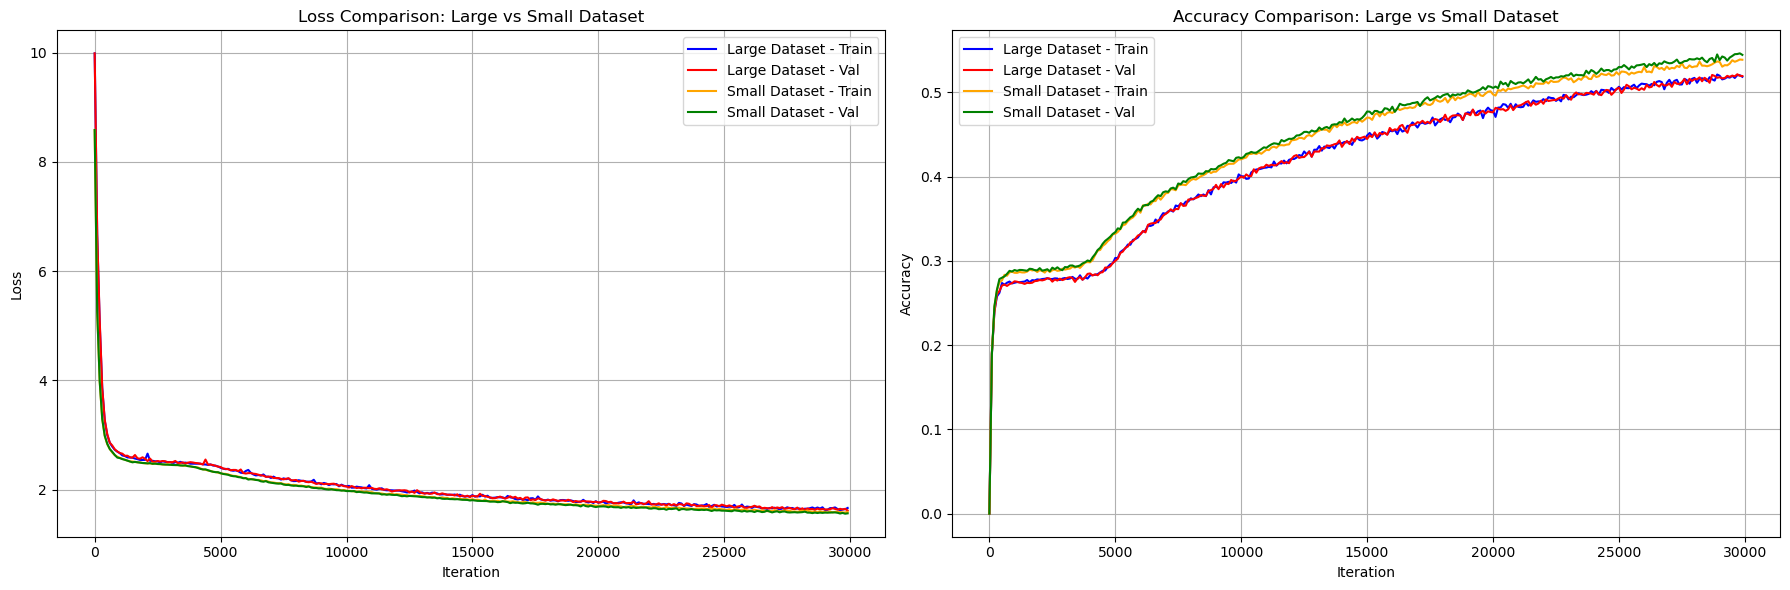

Direct comparison plot saved to results/direct_comparison_large_vs_small.png


In [2]:
# Direct comparison plot of both datasets on the same axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot loss for both datasets
ax1.plot(df_large['iteration'], df_large['train_loss'], label='Large Dataset - Train', color='blue')
ax1.plot(df_large['iteration'], df_large['val_loss'], label='Large Dataset - Val', color='red')
ax1.plot(df_small['iteration'], df_small['train_loss'], label='Small Dataset - Train', color='orange')
ax1.plot(df_small['iteration'], df_small['val_loss'], label='Small Dataset - Val', color='green')
ax1.set_title('Loss Comparison: Large vs Small Dataset')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plot accuracy for both datasets
ax2.plot(df_large['iteration'], df_large['train_acc'], label='Large Dataset - Train', color='blue')
ax2.plot(df_large['iteration'], df_large['val_acc'], label='Large Dataset - Val', color='red')
ax2.plot(df_small['iteration'], df_small['train_acc'], label='Small Dataset - Train', color='orange')
ax2.plot(df_small['iteration'], df_small['val_acc'], label='Small Dataset - Val', color='green')
ax2.set_title('Accuracy Comparison: Large vs Small Dataset')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig('results/direct_comparison_large_vs_small.png')
plt.show()

print("Direct comparison plot saved to results/direct_comparison_large_vs_small.png")